In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix, coo_matrix

# Детерминированные алгоритмы
from implicit.nearest_neighbours import ItemItemRecommender, CosineRecommender, TFIDFRecommender, BM25Recommender

# Метрики
from implicit.evaluation import train_test_split
from implicit.evaluation import precision_at_k, mean_average_precision_at_k, AUC_at_k, ndcg_at_k

In [2]:
data = pd.read_csv('retail_train/retail_train.csv')
data.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [3]:
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

In [34]:
data_train.shape[0], data_test.shape[0]

(2278490, 118314)

In [4]:
def precision_at_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    
    bought_list = bought_list  # Тут нет [:k] !!
    recommended_list = recommended_list[:k]
    
    flags = np.isin(bought_list, recommended_list)
    #print(flags)
    
    
    precision = flags.sum() / len(recommended_list)
    
    
    return precision

# Оценивание
За выполнени каждого задания 1 балл

4 балла -> отл

3 балла -> хор

И тд

### Задание 0. Товар 999999
На вебинаре мы использовали товар 999999 - что это за товар? Зачем он нужен. Используя этот товар мы смещяем качество рекомендаций. В какую сторону?  Можно ли удалить этот товар? Уберите этот товар и сравните с качеством на семинаре.

999999 - это индекс всех товаров не вошедшив в топ 5000. если размер товаров не ограничивать то размер
данных такой (2499, 86865)

In [6]:
#'Спсиок рекомендаций, если не ограничиваться топ 5000:

def str_to_list(data):    
    res = []
    for i in data.strip('][').split():
        res.append(int(i.rstrip(',')))
    return res

result_not5000 = pd.read_csv('not5000_predictions_basic.csv') # закгрузка predict с семианара

for col in result_not5000.iloc[:,1:]:
    result_not5000[col] = result_not5000.apply(lambda row: str_to_list(row[col]), axis=1)
result_not5000.head(2)

,user_id,actual,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[12610955, 9803248, 9798469, 1946014, 7443299]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 995242, 840361]","[1082185, 981760, 1127831, 13671834, 12487387]","[1082185, 13671834, 12487387, 12171883, 8091337]","[1082185, 995242, 1029743, 840361, 904360]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1373403, 9880531, 94548, 13769223, 15830550]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1098066, 826249, 995242]","[1082185, 1098066, 981760, 826249, 883404]","[1082185, 1098066, 981760, 826249, 883404]","[1082185, 1098066, 6534178, 826249, 1127831]"


In [7]:
for col in result_not5000.iloc[:,2:]:
    print(col, end=': ')
    print(result_not5000.apply(lambda row: precision_at_k(row[col], row['actual'], k=5), axis=1).mean())

random_recommendation: 0.0007835455435847209
popular_recommendation: 0.15523996082272082
itemitem: 0.15406464250734386
cosine: 0.1295788442703217
tfidf: 0.12291870714985192
own_purchases: 0.21909892262487482


In [8]:
#Результат второго задания:

# random_recommendation: 0.0005876591576885406
# popular_recommendation: 0.15523996082272082
# itemitem: 0.13692458374142857
# cosine: 0.13290891283055686
# tfidf: 0.1389813907933383
# own_purchases: 0.17969311132876015

Точность упала, но не на всех способах рекомендации. Во первых данных значительно больше (2499, 86865) против (2499, 5001), а вить мы это для экономии памяти делали. Товар 999999 символизирует все 86865 - 5000 = 81865 товаров не в топ 5000, я конечно не спец, но мне кажется представив 81865 как один мы проиграли в рекомендациях.

### Задание 1. Weighted Random Recommendation

Напишите код для случайных рекоммендаций, в которых вероятность рекомендовать товар прямо пропорциональна логарифму продаж
- Можно сэмплировать товары случайно, но пропорционально какому-либо весу
- Например, прямопропорционально популярности. Вес = log(sales_sum товара)

In [9]:
def weighted_random_recommendation(items_weights, n=5):
    """Случайные рекоммендации
    
    Input
    -----
    items_weights: pd.DataFrame
        Датафрейм со столбцами item_id, weight. Сумма weight по всем товарам = 1
    """
    
    # Подсказка: необходимо модифицировать функцию random_recommendation()
    # your_code
    
    item_id = np.array(items_weights['item_id'])
    recs = np.random.choice(item_id, size=n, replace=False, p=items_weights['weight'].tolist())
    
    return recs.tolist()

Сделайте предсказания

In [10]:
%%time

# your_code
items_weights = data_train.groupby('item_id')['sales_value'].sum().reset_index()
items_weights.loc[items_weights['sales_value'] < 1] = 1
items_weights['weight'] = items_weights['sales_value'].apply(np.log)
items_weights['weight'] = items_weights['weight'] / items_weights['weight'].sum()
items_weights.head()

Wall time: 170 ms


,item_id,sales_value,weight
0,25671,20.94,0.000013
1,1,1.00,0.000000
2,26093,1.59,0.000002
3,26190,1.54,0.000002
4,26355,1.98,0.000003


In [11]:
weighted_random_recommendation(items_weights)

[1125382, 12383763, 864344, 13417759, 1083583]

### Задание 2. Расчет метрик
Рассчитайте Precision@5 для каждого алгоритма с помощью функции из вебинара 1. Какой алгоритм показывает лучшее качество?

In [12]:
result = pd.read_csv('predictions_basic.csv') # закгрузка predict с семианара
result.head(2)

,user_id,actual,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases
0,1,[ 821867 834484 856942 865456 889248 ...,"[12352331, 941170, 7167516, 8018999, 8293241]","[6534178, 6533889, 1029743, 6534166, 1082185]","[999999, 1082185, 981760, 1127831, 995242]","[1082185, 999999, 981760, 1127831, 1098066]","[1082185, 981760, 1127831, 999999, 1098066]","[999999, 1082185, 1029743, 995785, 1004906]"
1,3,[ 835476 851057 872021 878302 879948 ...,"[907827, 5568792, 10204833, 5592577, 1537376]","[6534178, 6533889, 1029743, 6534166, 1082185]","[999999, 1082185, 981760, 1098066, 995242]","[1082185, 1098066, 981760, 999999, 826249]","[1082185, 981760, 1098066, 826249, 999999]","[999999, 1082185, 1098066, 6534178, 1127831]"


In [13]:
for col in result.iloc[:,1:]:
    result[col] = result.apply(lambda row: str_to_list(row[col]), axis=1)
result.head(2)

,user_id,actual,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[12352331, 941170, 7167516, 8018999, 8293241]","[6534178, 6533889, 1029743, 6534166, 1082185]","[999999, 1082185, 981760, 1127831, 995242]","[1082185, 999999, 981760, 1127831, 1098066]","[1082185, 981760, 1127831, 999999, 1098066]","[999999, 1082185, 1029743, 995785, 1004906]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[907827, 5568792, 10204833, 5592577, 1537376]","[6534178, 6533889, 1029743, 6534166, 1082185]","[999999, 1082185, 981760, 1098066, 995242]","[1082185, 1098066, 981760, 999999, 826249]","[1082185, 981760, 1098066, 826249, 999999]","[999999, 1082185, 1098066, 6534178, 1127831]"


In [14]:
result['random_waihgt'] = result['user_id'].apply(lambda x: weighted_random_recommendation(items_weights, n=5))

In [15]:
# your_code

for col in result.iloc[:,2:]:
    print(col, end=': ')
    print(result.apply(lambda row: precision_at_k(row[col], row['actual'], k=5), axis=1).mean())

random_recommendation: 0.00039177277179236047
popular_recommendation: 0.15523996082272082
itemitem: 0.13692458374142857
cosine: 0.13290891283055686
tfidf: 0.1389813907933383
own_purchases: 0.17969311132876015
random_waihgt: 0.001567091087169442


In [16]:
# Луший ItemItemRecommender(K=1, num_threads=4) трюк


### Задание 3. Улучшение бейзлайнов и ItemItem

- Попробуйте улучшить бейзлайны, считая их на топ-5000 товаров
- Попробуйте улучшить разные варианты ItemItemRecommender, выбирая число соседей $K$.
-  *Попробуйте стратегии ансамблирования изученных алгоритмов

Обязательно нужно сделать первые 2 пункта!

In [33]:
popularity.head()

,item_id,n_sold
0,202291,35911
1,397896,1214994
2,420647,168661
3,480014,371107
4,545926,20134


In [32]:
# your_code

popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

# Заведем фиктивный item_id (если юзер НЕ покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity',
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix[user_item_matrix > 0] = 1 # так как в итоге хотим предсказать 
user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [20]:
user_item_matrix.shape

(2499, 5000)

In [35]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(10)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 999999, 91419..."
1,3,"[999999, 851057, 872021, 878302, 879948, 90963..."
2,6,"[920308, 926804, 999999, 1017061, 1078346, 112..."
3,7,"[840386, 889774, 898068, 909714, 999999, 95347..."
4,8,"[835098, 872137, 910439, 924610, 999999, 10412..."
5,9,"[864335, 999999, 1029743, 9297474, 889692, 919..."
6,13,"[6534178, 999999, 840361, 862070, 884897, 9203..."
7,14,"[840601, 999999, 933067, 951590, 952408, 96569..."
8,15,"[910439, 1082185, 959076, 1023958, 1082310, 99..."
9,16,"[1062973, 1082185, 999999]"


In [39]:
model = ItemItemRecommender(K=5, num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

result['itemitem'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)])

In [46]:
%%time

for K in range(1, 20): 
    model = ItemItemRecommender(K=K, num_threads=4)

    model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=False)
    

    result[f'K-{K}'] = result['user_id'].\
                                    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                                    model.recommend(userid=userid_to_id[x], 
                                        user_items=sparse_user_item,   # на вход user-item matrix
                                        N=5, 
                                        filter_already_liked_items=False, 
                                        filter_items=None, 
                                        recalculate_user=True)])

Wall time: 15.1 s


In [47]:
result.head()

,user_id,actual,itemitem,K-1,K-2,K-3,K-4,K-5,K-6,K-7,...,K-10,K-11,K-12,K-13,K-14,K-15,K-16,K-17,K-18,K-19
0,1,"[821867, 834484, 856942, 865456, 999999, 91419...","[999999, 1082185, 981760, 1127831, 995242]","[999999, 1082185, 1029743, 995785, 1004906]","[999999, 1082185, 995242, 1029743, 840361]","[999999, 1082185, 981760, 995242, 1029743]","[999999, 1082185, 981760, 995242, 1127831]","[999999, 1082185, 981760, 1127831, 995242]","[999999, 1082185, 981760, 1127831, 995242]","[999999, 1082185, 981760, 995242, 840361]",...,"[999999, 1082185, 981760, 995242, 840361]","[999999, 1082185, 981760, 995242, 840361]","[999999, 1082185, 981760, 995242, 840361]","[999999, 1082185, 981760, 995242, 840361]","[999999, 1082185, 981760, 995242, 840361]","[999999, 1082185, 981760, 995242, 840361]","[999999, 1082185, 981760, 995242, 840361]","[999999, 1082185, 981760, 995242, 840361]","[999999, 1082185, 981760, 995242, 840361]","[999999, 1082185, 981760, 995242, 1127831]"
1,3,"[999999, 851057, 872021, 878302, 879948, 90963...","[999999, 1082185, 981760, 1098066, 995242]","[999999, 1082185, 1098066, 6534178, 1127831]","[999999, 1082185, 1098066, 6534178, 826249]","[999999, 1082185, 981760, 1098066, 6534178]","[999999, 1082185, 981760, 1098066, 826249]","[999999, 1082185, 981760, 1098066, 995242]","[999999, 1082185, 981760, 1098066, 826249]","[999999, 1082185, 981760, 1098066, 826249]",...,"[999999, 1082185, 981760, 1098066, 826249]","[999999, 1082185, 981760, 1098066, 826249]","[999999, 1082185, 981760, 1098066, 826249]","[999999, 1082185, 981760, 1098066, 826249]","[999999, 1082185, 981760, 1098066, 826249]","[999999, 1082185, 981760, 1098066, 826249]","[999999, 1082185, 981760, 1098066, 826249]","[999999, 1082185, 981760, 1098066, 826249]","[999999, 1082185, 981760, 1098066, 826249]","[999999, 1082185, 981760, 1098066, 826249]"
2,6,"[920308, 926804, 999999, 1017061, 1078346, 112...","[999999, 1082185, 981760, 1127831, 995242]","[999999, 1082185, 1029743, 6534178, 1127831]","[999999, 1082185, 981760, 995242, 1029743]","[999999, 1082185, 981760, 995242, 1029743]","[999999, 1082185, 981760, 1127831, 995242]","[999999, 1082185, 981760, 1127831, 995242]","[999999, 1082185, 981760, 1127831, 995242]","[999999, 1082185, 981760, 995242, 1098066]",...,"[999999, 1082185, 981760, 995242, 840361]","[999999, 1082185, 981760, 840361, 995242]","[999999, 1082185, 981760, 840361, 995242]","[999999, 1082185, 981760, 840361, 995242]","[999999, 1082185, 981760, 840361, 995242]","[999999, 1082185, 981760, 840361, 995242]","[999999, 1082185, 981760, 840361, 995242]","[999999, 1082185, 981760, 840361, 995242]","[999999, 1082185, 981760, 840361, 995242]","[999999, 1082185, 981760, 840361, 995242]"
3,7,"[840386, 889774, 898068, 909714, 999999, 95347...","[999999, 1082185, 981760, 1127831, 995242]","[999999, 1082185, 1029743, 1127831, 995785]","[999999, 1082185, 995242, 1029743, 826249]","[999999, 1082185, 981760, 995242, 1029743]","[999999, 1082185, 981760, 1127831, 995242]","[999999, 1082185, 981760, 1127831, 995242]","[999999, 1082185, 981760, 1127831, 995242]","[999999, 1082185, 981760, 1098066, 995242]",...,"[999999, 1082185, 981760, 995242, 1098066]","[999999, 1082185, 981760, 995242, 840361]","[999999, 1082185, 981760, 995242, 840361]","[999999, 1082185, 981760, 995242, 840361]","[999999, 1082185, 981760, 995242, 840361]","[999999, 1082185, 981760, 995242, 840361]","[999999, 1082185, 981760, 995242, 840361]","[999999, 1082185, 981760, 995242, 840361]","[999999, 1082185, 981760, 995242, 840361]","[999999, 1082185, 981760, 995242, 840361]"
4,8,"[835098, 872137, 910439, 924610, 999999, 10412...","[999999, 1082185, 981760, 1127831, 1098066]","[999999, 1082185, 1029743, 1098066, 6534178]","[999999, 1082185, 981760, 995242, 1029743]","[999999, 1082185, 981760, 6534178, 995242]","[999999, 1082185, 981760, 1127831, 995242]","[999999, 1082185, 981760, 1127831, 1098066]","[999999, 1082185, 981760, 1098066, 995242]","[999999, 1082185, 981760, 1098066, 995242]",...,"[999999, 

In [49]:
precision_arr = list()

for col in result.iloc[:,2:]:
    print(col, end=': ')
    precision_arr.append(result.apply(lambda row: precision_at_k(row[col], row['actual'], k=5), axis=1).mean())
    print(precision_arr[-1])

itemitem: 0.33104799216454495
K-1: 0.37788116225922463
K-2: 0.38713679399281997
K-3: 0.3805664381325523
K-4: 0.33920176297747384
K-5: 0.33104799216454495
K-6: 0.33614103819784596
K-7: 0.3389813907933407
K-8: 0.341332027424095
K-9: 0.34260528893242026
K-10: 0.3450538687561228
K-11: 0.3463271302644481
K-12: 0.3475024485798253
K-13: 0.3473065621939291
K-14: 0.34760039177277346
K-15: 0.34730656219392914
K-16: 0.3475024485798254
K-17: 0.34730656219392914
K-18: 0.3475024485798254
K-19: 0.3475024485798253


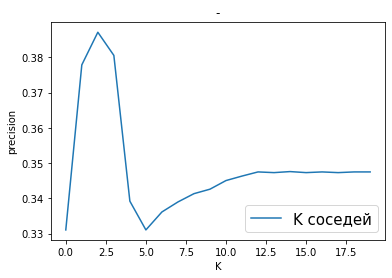

In [57]:
import matplotlib.pyplot as plt

plt.plot(precision_arr, label='K соседей')

plt.xlabel('K')
plt.ylabel('precision')
plt.title('-')
plt.legend(loc="lower right", prop={'size': 15})
plt.show()

Если хоти предсказывать пользователю не только то, что он уже покупал, еще какой нибудь новый товар самым оптимальным будет K=12.

### Задание 4. Улучшение детерминированных алгоритмов
На семинаре мы рассматривали 



Далее $U \equiv N_i(u) $

$$r_{u,i} =  \frac{1}{S}\sum\limits_{v \in U}\operatorname{sim}(u,v)r_{v, i}$$
$$ S = \sum\limits_{v \in U} \operatorname{sim}(u,v)$$

Предлагается улучшить эту формулу и учесть средние предпочтения всех пользователей

$$r_{u,i} = \mu + \bar{r_u} + \frac{1}{S}\sum\limits_{v \in U}\operatorname{sim}(u,v)(r_{v, i}-\bar{r_{v}} - \mu)$$

Какие смысл имееют $ \mu $ и $ \bar{r_u}$ ?

Реализуйте алгоритм, прогнозирующий рейтинги на основе данной формулы, на numpy (векторизованно!)

В качестве схожести возьмите CosineSimilarity.

Примените к user_item_matrix. В качестве рейтингов возьмите количество или стоимость купленного товара. 
Данный алгоритм предсказывает рейтинги. Как на основании предсказанных рейтингов предсказать факт покупки?

Предложите вариант.
Посчитайте accuracy@5 и сравните с алгоритмами, разобранными на вебинаре.